## Dependencies

In [18]:
!pip install --upgrade pip
!pip install --upgrade mediapipe
!pip install --upgrade tensorflow
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install gtts
!pip install flask pyngrok tensorflow numpy



In [ ]:
import os

os.makedirs('data', exist_ok=True)

os.makedirs('models', exist_ok=True)

import os
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import kagglehub
import json
import time
import threading
import re
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from gtts import gTTS
from IPython.display import Audio
import io
import tempfile

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

import kagglehub

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import mediapipe as mp

from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

## check model

In [ ]:

os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('temp', exist_ok=True)


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

SIGN_EMOJIS = {
    'a': '👆', 'b': '✋', 'c': '👌', 'd': '👍', 'e': '👋', 'f': '👊',
    'g': '👇', 'h': '👐', 'i': '🤙', 'j': '🤞', 'k': '🖐️', 'l': '👉',
    'm': '🤛', 'n': '🤜', 'o': '⭕', 'p': '👌', 'q': '👇', 'r': '🤘',
    's': '✊', 't': '👆', 'u': '✌️', 'v': '✌️', 'w': '👐', 'x': '🤞',
    'y': '🤙', 'z': '👈', '0': '⭕', '1': '☝️', '2': '✌️', '3': '🤟',
    '4': '🖖', '5': '🖐️', '6': '👌', '7': '🤞', '8': '👌', '9': '✊',
    ' ': ' ', '.': '✋', '?': '🤔', '!': '❗'
}

ASL_PHRASES = {
    "hello": "👋",
    "thank you": "🙏",
    "please": "🤲",
    "sorry": "👊❤️",
    "yes": "👍",
    "no": "👎",
    "help": "✊👆",
    "learn": "👉👂",
    "understand": "👉👁️👍",
    "good": "👍",
    "bad": "👎",
    "love": "🤟",
    "friend": "👉👈"
}

LEARNING_MODULES = {
    "basics": {
        "title": "ASL Basics",
        "description": "Learn the alphabet and numbers in American Sign Language",
        "lessons": [
            {"id": "alphabet", "title": "ASL Alphabet", "content": "Practice recognizing and forming the ASL alphabet"},
            {"id": "numbers", "title": "ASL Numbers", "content": "Learn to count from 0-9 in ASL"}
        ]
    },
    "phrases": {
        "title": "Common Phrases",
        "description": "Essential everyday phrases in ASL",
        "lessons": [
            {"id": "greetings", "title": "Greetings", "content": "Learn common greetings like 'hello', 'goodbye', 'how are you'"},
            {"id": "questions", "title": "Basic Questions", "content": "Learn to ask questions in ASL"}
        ]
    }
}

def download_kaggle_dataset():
    """Download ASL dataset from Kaggle and return the path"""
    print("Downloading ASL dataset from Kaggle...")
    path = kagglehub.dataset_download("ayuraj/asl-dataset")
    print("Path to dataset files:", path)
    return path

def explore_dataset(dataset_path):
    """Explore the structure of the downloaded dataset"""
    print(f"\nExploring dataset at path: {dataset_path}")
    if not os.path.exists(dataset_path):
        print(f"Error: Path {dataset_path} does not exist.")
        return None, None
    print("\nContents at the root level:")
    root_contents = os.listdir(dataset_path)
    for item in root_contents:
        full_path = os.path.join(dataset_path, item)
        if os.path.isdir(full_path):
            print(f"- Directory: {item}")
        else:
            print(f"- File: {item}")
    asl_dir = dataset_path
    for item in root_contents:
        if item.lower().startswith('asl') and os.path.isdir(os.path.join(dataset_path, item)):
            asl_dir = os.path.join(dataset_path, item)
            print(f"\nFound potential ASL directory: {asl_dir}")
    print("\nExploring dataset structure...")
    for root, dirs, files in os.walk(asl_dir):
        level = root.replace(asl_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        if level <= 1:
            for file in files[:5]:
                print(f"{indent}    {file}")
            if len(files) > 5:
                print(f"{indent}    ... and {len(files)-5} more files")
    class_counts = {}
    class_dirs = [d for d in os.listdir(asl_dir) if os.path.isdir(os.path.join(asl_dir, d))]
    if not class_dirs:
        print("\nNo class directories found. The dataset might have a different structure.")
        return None, None
    sign_dict = {}
    for i, class_name in enumerate(sorted(class_dirs)):
        label = class_name
        sign_dict[i] = label
        class_path = os.path.join(asl_dir, class_name)
        if os.path.isdir(class_path):
            file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = file_count
    if class_counts:
        print("\nNumber of images per class:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count} images")
        total_images = sum(class_counts.values())
        total_classes = len(class_counts)
        print(f"\nTotal: {total_images} images across {total_classes} classes")
        print("\nShowing sample images from different classes...")
        plt.figure(figsize=(15, 10))
        samples_shown = 0
        for i, class_name in enumerate(sorted(class_counts.keys())[:5]):
            class_path = os.path.join(asl_dir, class_name)
            image_files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                          if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            sample_images = image_files[:3]
            for j, img_path in enumerate(sample_images):
                samples_shown += 1
                ax = plt.subplot(5, 3, samples_shown)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError(f"Failed to read image: {img_path}")
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img)
                    plt.title(f"{class_name}")
                    plt.axis('off')
                except Exception as e:
                    print(f"Error displaying image {img_path}: {e}")
                    plt.text(0.5, 0.5, f"Error loading\n{os.path.basename(img_path)}",
                            ha='center', va='center')
                    plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No class directories found with images.")
    return asl_dir, sign_dict

def extract_landmarks_from_dataset(dataset_path, max_samples_per_class=None):
    """Extract hand landmarks from ASL dataset images"""
    print(f"Extracting hand landmarks from dataset images at: {dataset_path}")
    X = []
    y = []
    sign_dict = {}
    os.makedirs('data', exist_ok=True)
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    if not class_dirs:
        print("No class directories found!")
        return [], [], {}
    class_mapping = {}
    for i in range(10):
        class_mapping[str(i)] = i
    for i, letter in enumerate("abcdefghijklmnopqrstuvwxyz"):
        class_mapping[letter] = i + 10
    print("Class mapping:")
    for folder, idx in sorted(class_mapping.items()):
        print(f"  Folder '{folder}' → Class {idx}")
    processed_classes = set()
    for class_name in sorted(class_dirs):
        if class_name not in class_mapping:
            print(f"Warning: Unexpected folder '{class_name}' - skipping")
            continue
        class_idx = class_mapping[class_name]
        processed_classes.add(class_idx)
        sign_dict[str(class_idx)] = class_name
        class_dir = os.path.join(dataset_path, class_name)
        print(f"Processing class: {class_name} (ID: {class_idx})")
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                      if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_samples_per_class:
            image_files = image_files[:max_samples_per_class]
        for i, img_path in enumerate(image_files):
            if i % 50 == 0:
                print(f"  Processing image {i+1}/{len(image_files)}...")
            try:
                frame = cv2.imread(img_path)
                if frame is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                _, landmarks_list = process_frame(frame)
                if landmarks_list:
                    landmarks = landmarks_list[0]
                    X.append(np.array(landmarks).flatten())
                    y.append(class_idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    X = np.array(X) if X else np.array([])
    y = np.array(y) if y else np.array([])
    if len(X) > 0:
        print(f"Extracted landmarks from {len(X)} images across {len(processed_classes)} classes")
        all_expected_classes = set(class_mapping.values())
        missing_classes = all_expected_classes - processed_classes
        if missing_classes:
            print(f"Warning: The following classes have no samples: {sorted(missing_classes)}")
        np.save('data/kaggle_landmarks.npy', X)
        np.save('data/kaggle_labels.npy', y)
        with open('data/sign_dict.json', 'w') as f:
            json.dump(sign_dict, f)
    else:
        print("No landmarks were extracted. Check that the dataset contains valid images with hands.")
    class_sample_counts = {}
    for label in y:
        class_sample_counts[label] = class_sample_counts.get(label, 0) + 1
    print("Samples extracted per class:")
    for class_idx, count in sorted(class_sample_counts.items()):
        class_name = sign_dict.get(str(class_idx), f"Class {class_idx}")
        print(f"  {class_name}: {count} samples")
    print(f"Total classes with samples: {len(class_sample_counts)}")
    return X, y, sign_dict

def process_frame(frame):
    """Process a frame with MediaPipe Hands"""
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5) as hands:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        processed_frame = frame.copy()
        landmarks_list = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
                landmarks_list.append(landmarks)
                mp_drawing.draw_landmarks(
                    processed_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        return processed_frame, landmarks_list

def train_model(X, y, num_classes, sign_dict):
    """Train a model on the extracted landmarks and display performance charts."""
    print("Training model on extracted landmarks...")
    os.makedirs('models', exist_ok=True)
    unique_classes = np.unique(y)
    actual_num_classes = len(unique_classes)
    print(f"Found {actual_num_classes} unique classes in the data")
    max_class = np.max(unique_classes)
    print(f"Maximum class label: {max_class}")
    if max_class >= num_classes:
        adjusted_num_classes = max_class + 1
        print(f"Adjusting num_classes from {num_classes} to {adjusted_num_classes}")
        num_classes = adjusted_num_classes
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)
    input_shape = X_train.shape[1]
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[early_stop])
    val_loss, val_acc = model.evaluate(X_val, y_val_one_hot)
    print(f"\nValidation accuracy: {val_acc:.4f}")
    model.save('models/sign_language_model.h5')
    print("Model saved to models/sign_language_model.h5")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    unique_val_classes = np.unique(y_val)
    target_names = [sign_dict.get(str(int(i)), f"Class {i}") for i in unique_val_classes]
    print("\nClassification Report:")
    print(classification_report(y_val, np.argmax(model.predict(X_val), axis=1), labels=unique_val_classes, target_names=target_names))

    # Plot training history: accuracy and loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, history

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def take_photo(filename='test_photo.jpg'):
    """Take a photo with the webcam in Google Colab"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => { capture.onclick = resolve; });
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg');
        }
        ''')
    display(js)
    print("Click 'Capture' when ready to take a photo.")
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    frame = cv2.imread(filename)
    if frame is None:
        raise Exception(f"Failed to read the saved image from {filename}")
    print(f"Photo saved to {filename}")
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)
    return frame


def text_to_sign(text):
    """
    Convert text to sign language representations (using emojis as placeholders)
    """
    text = text.lower()
    for phrase, emoji in ASL_PHRASES.items():
        text = text.replace(phrase, f" {emoji} ")
    result = ""
    for char in text:
        if char in SIGN_EMOJIS:
            result += SIGN_EMOJIS[char] + " "
        else:
            result += char + " "
    return result

def text_to_speech(text):
    """
    Convert text to speech using gTTS
    """
    tts = gTTS(text=text, lang='en')
    with tempfile.NamedTemporaryFile(suffix='.mp3', delete=False) as f:
        temp_filename = f.name
    tts.save(temp_filename)
    display(Audio(temp_filename, autoplay=True))
    def delete_file():
        time.sleep(5)
        os.unlink(temp_filename)
    threading.Thread(target=delete_file).start()


detected_sentence = ""

def sign_to_text_realtime():
    """
    Detect sign language in real-time from webcam, convert to text,
    and form a written sentence for easier understanding.
    Press the 'Stop' button to end real-time detection.
    """
    global detected_sentence
    detected_sentence = ""  
    if os.path.exists('models/sign_language_model.h5'):
        model = tf.keras.models.load_model('models/sign_language_model.h5')
    else:
        print("No model found. Please train the model first.")
        return
    with open('data/sign_dict.json', 'r') as f:
        sign_dict = json.load(f)
    js_code = """
    var div = document.createElement('div');
    document.body.appendChild(div);
    var video = document.createElement('video');
    var canvas = document.createElement('canvas');
    var stopButton = document.createElement('button');
    stopButton.textContent = 'Stop';
    div.appendChild(video);
    div.appendChild(document.createElement('br'));
    div.appendChild(canvas);
    div.appendChild(document.createElement('br'));
    div.appendChild(stopButton);
    canvas.width = 640;
    canvas.height = 480;
    video.width = 640;
    video.height = 480;
    var ctx = canvas.getContext('2d');
    var stream;
    var intervalId;
    var isRunning = true;
    stopButton.onclick = function() {
        isRunning = false;
        if (intervalId) clearInterval(intervalId);
        if (stream) { stream.getTracks().forEach(track => track.stop()); }
        div.remove();
        google.colab.kernel.invokeFunction('notebook.capture_stopped', [], {});
    };
    navigator.mediaDevices.getUserMedia({video: true}).then(function(s) {
        stream = s;
        video.srcObject = stream;
        video.play();
        intervalId = setInterval(function() {
            if (!isRunning) return;
            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
            var imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.process_frame', [imageData], {});
        }, 100);
    }).catch(function(err) {
        console.error("Error accessing webcam: " + err);
    });
    """
    from google.colab import output
    previous_sign = [None]
    def process_frame_callback(image_data):
        global detected_sentence
        header, encoded = image_data.split(",", 1)
        data = np.frombuffer(b64decode(encoded), np.uint8)
        frame = cv2.imdecode(data, cv2.IMREAD_COLOR)
        processed_frame, landmarks_list = process_frame(frame)
        if landmarks_list:
            landmarks = np.array(landmarks_list[0]).flatten().reshape(1, -1)
            pred = model.predict(landmarks)
            class_idx = np.argmax(pred)
            recognized = sign_dict.get(str(class_idx), "Unknown")
        else:
            recognized = ""
        if recognized and recognized != previous_sign[0]:
            detected_sentence += recognized + " "
            previous_sign[0] = recognized
        clear_output(wait=True)
        display(HTML(f"<h3>Detected Sentence:</h3><p>{detected_sentence.strip()}</p>"))
    def capture_stopped_callback():
        clear_output(wait=True)
        display(HTML(f"<h3>Final Detected Sentence:</h3><p>{detected_sentence.strip()}</p>"))
        print("Real-time sign language detection stopped.")
    output.register_callback('notebook.process_frame', process_frame_callback)
    output.register_callback('notebook.capture_stopped', capture_stopped_callback)
    display(Javascript(js_code))


def interactive_learning_modules():
    print("Interactive Learning Modules")
    for module_key, module_info in LEARNING_MODULES.items():
        print(f"\nModule: {module_info['title']}")
        print(f"Description: {module_info['description']}")
        for lesson in module_info['lessons']:
            print(f"  Lesson: {lesson['title']}")
            print(f"    Content: {lesson['content']}")

def track_progress(progress_data):
    print("AI-Based Progress Tracking")
    for lesson, score in progress_data.items():
        print(f"Lesson: {lesson}, Score: {score}")
    print("Recommendations: Keep practicing and review lessons with scores below 70%.")


def main():
    print("Select conversion mode:")
    print("1: Text to Sign")
    print("2: Sign to Text (Real-time)")
    print("3: Interactive Learning Modules")
    mode = input("Enter mode number: ")
    if mode == "1":
        text = input("Enter text: ")
        sign = text_to_sign(text)
        print("\nSign language conversion (emojis):")
        print(sign)
        text_to_speech(text)
    elif mode == "2":
        print("Starting real-time sign language detection. Press 'Stop' to end.")
        sign_to_text_realtime()
    elif mode == "3":
        interactive_learning_modules()
        progress_data = {"ASL Alphabet": 80, "ASL Numbers": 65, "Greetings": 90}
        track_progress(progress_data)
    else:
        print("Invalid mode.")

100%|██████████| 56.9M/56.9M [00:00<00:00, 200MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1

Exploring dataset at path: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1

Contents at the root level:
- Directory: asl_dataset

Found potential ASL directory: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1/asl_dataset

Exploring dataset structure...
asl_dataset/
    6/
        hand5_6_dif_seg_5_cropped.jpeg
        hand2_6_right_seg_3_cropped.jpeg
        hand2_6_right_seg_1_cropped.jpeg
        hand1_6_top_seg_3_cropped.jpeg
        hand2_6_top_seg_1_cropped.jpeg
        ... and 65 more files
    c/
        hand2_c_bot_seg_4_cropped.jpeg
        hand4_c_bot_seg_1_cropped.jpeg
        hand2_c_dif_seg_1_cropped.jpeg
        hand1_c_bot_seg_4_cropped.jpeg
        hand5_c_bot_seg_3_cropped.jpeg
        ... and 65 more files
    f/
        hand2_f_left_seg_5_cropped.jpeg
        hand2_f_top_seg_1_cropped.jpeg
        hand2_f_dif_seg_1_cropped.jpeg
        hand5_f_dif_seg_3_c

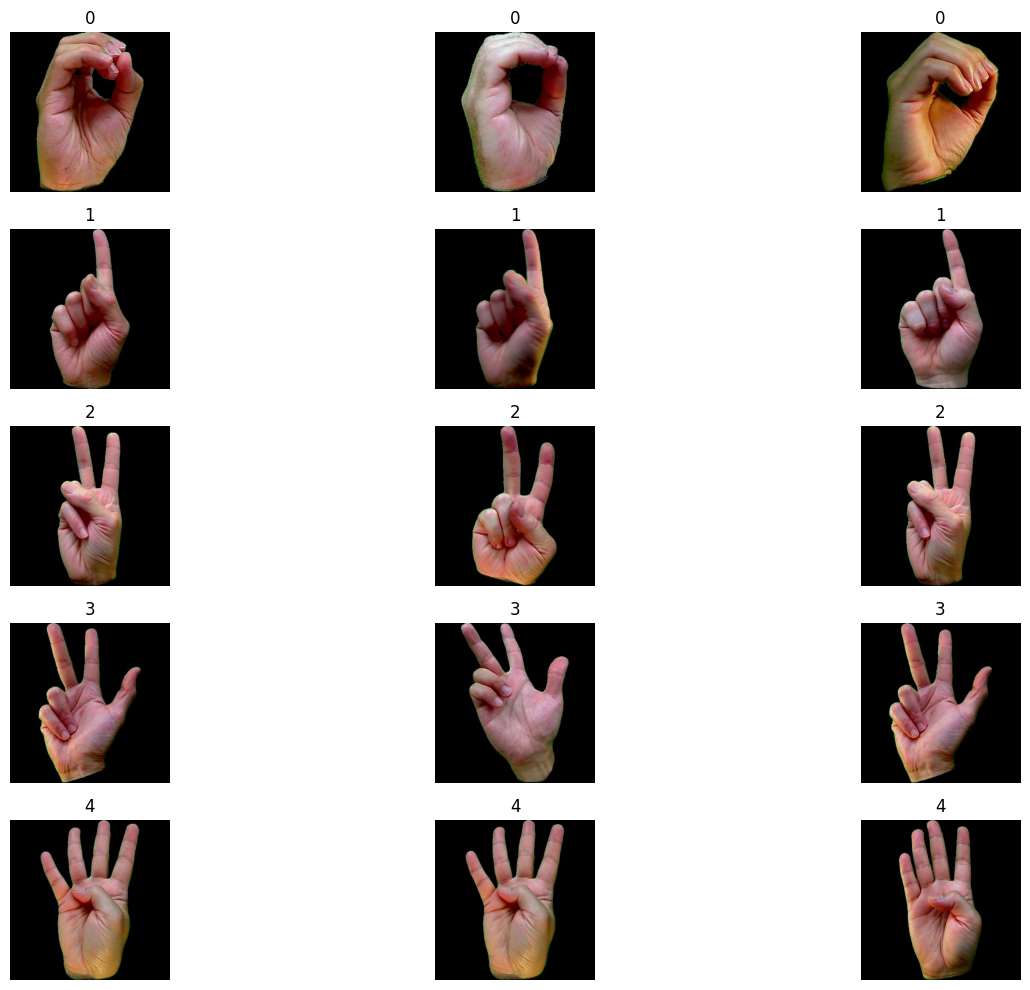

Extracting hand landmarks from dataset images at: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1/asl_dataset
Class mapping:
  Folder '0' → Class 0
  Folder '1' → Class 1
  Folder '2' → Class 2
  Folder '3' → Class 3
  Folder '4' → Class 4
  Folder '5' → Class 5
  Folder '6' → Class 6
  Folder '7' → Class 7
  Folder '8' → Class 8
  Folder '9' → Class 9
  Folder 'a' → Class 10
  Folder 'b' → Class 11
  Folder 'c' → Class 12
  Folder 'd' → Class 13
  Folder 'e' → Class 14
  Folder 'f' → Class 15
  Folder 'g' → Class 16
  Folder 'h' → Class 17
  Folder 'i' → Class 18
  Folder 'j' → Class 19
  Folder 'k' → Class 20
  Folder 'l' → Class 21
  Folder 'm' → Class 22
  Folder 'n' → Class 23
  Folder 'o' → Class 24
  Folder 'p' → Class 25
  Folder 'q' → Class 26
  Folder 'r' → Class 27
  Folder 's' → Class 28
  Folder 't' → Class 29
  Folder 'u' → Class 30
  Folder 'v' → Class 31
  Folder 'w' → Class 32
  Folder 'x' → Class 33
  Folder 'y' → Class 34
  Folder 'z' → Class 35
Process

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1801 - loss: 3.3912 - val_accuracy: 0.2462 - val_loss: 3.3449
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5959 - loss: 1.4836 - val_accuracy: 0.1046 - val_loss: 3.1157
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7536 - loss: 0.9439 - val_accuracy: 0.0738 - val_loss: 2.8976
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7427 - loss: 0.8344 - val_accuracy: 0.1138 - val_loss: 2.6506
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8204 - loss: 0.6265 - val_accuracy: 0.1662 - val_loss: 2.3511
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8323 - loss: 0.5452 - val_accuracy: 0.2031 - val_loss: 2.2338
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8304 - loss: 0.5152 - val_accuracy: 0.2615 - val_loss: 1.9544
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8383 - loss: 0.4884 - val_accuracy: 0.5015 - val_loss: 1.4880
Ep


Validation accuracy: 0.9108
Model saved to models/sign_language_model.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<Figure size 1200x1000 with 0 Axes>

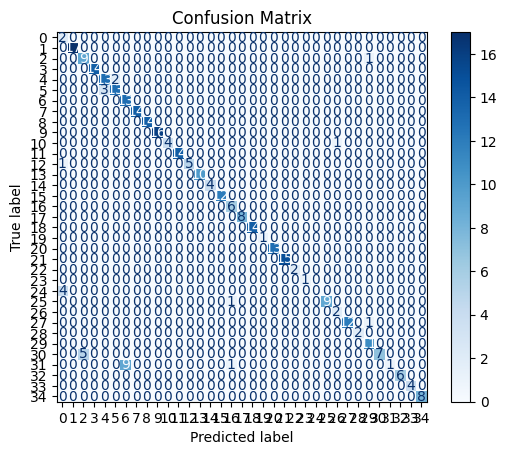


Classification Report:
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       1.00      1.00      1.00        17
           2       0.64      0.90      0.75        10
           3       1.00      1.00      1.00        14
           4       0.81      0.87      0.84        15
           5       0.87      0.81      0.84        16
           6       0.59      1.00      0.74        13
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        16
           a       1.00      0.80      0.89         5
           b       1.00      1.00      1.00        14
           c       1.00      0.83      0.91         6
           d       1.00      1.00      1.00        10
           e       1.00      1.00      1.00         4
           f       1.00      1.00      1.00        12
           g     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


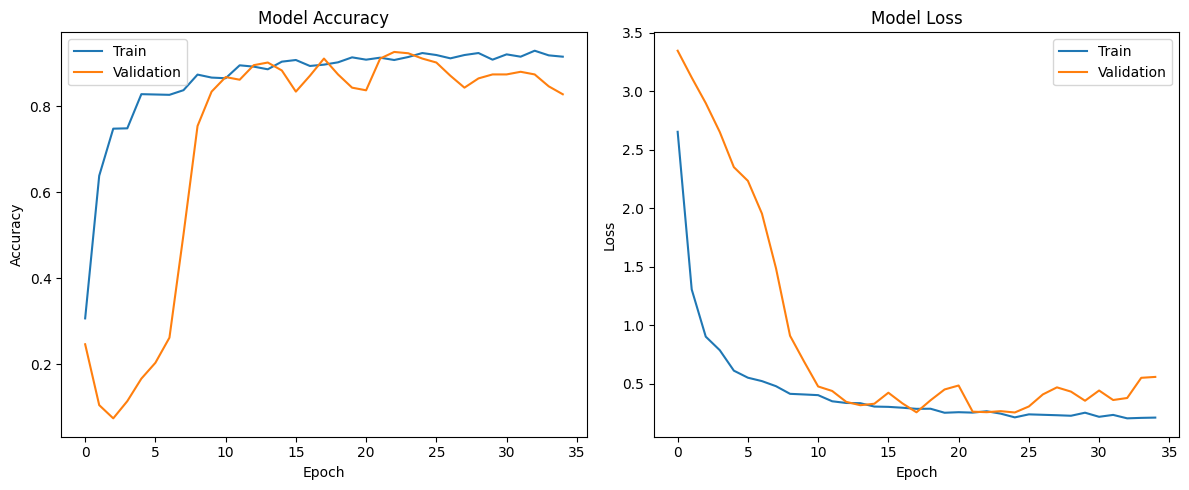

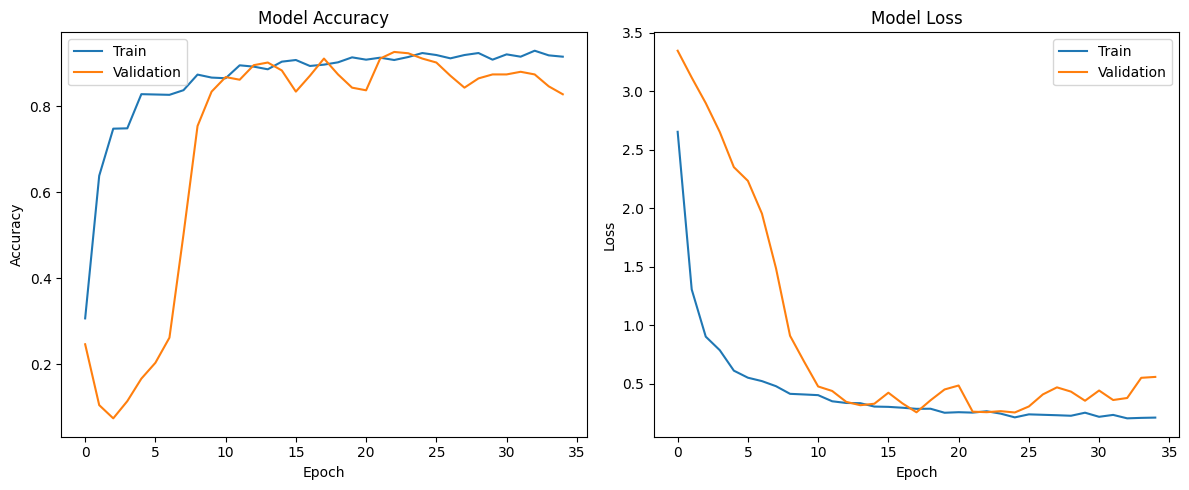

Select conversion mode:
1: Text to Sign
2: Sign to Text (Real-time)
3: Interactive Learning Modules
Enter mode number: 1
Enter text: 45554

Sign language conversion (emojis):
🖖 🖐️ 🖐️ 🖐️ 🖖 


In [4]:
if __name__ == '__main__':

    dataset_path = download_kaggle_dataset()
    asl_dir, sign_dict = explore_dataset(dataset_path)

    X, y, sign_dict = extract_landmarks_from_dataset(asl_dir, max_samples_per_class=70)
    if len(X) > 0:
        model, history = train_model(X, y, num_classes=len(np.unique(y)), sign_dict=sign_dict)
        plot_training_history(history)
    main()


In [ ]:
from fastapi import FastAPI, HTTPException
from pyngrok import ngrok, conf
import tensorflow as tf
import uvicorn
import os
import nest_asyncio
import threading

# Apply Nest Asyncio Fix
nest_asyncio.apply()

app = FastAPI()

# Authenticate ngrok (Replace with your actual authtoken)
conf.get_default().auth_token = "2v2iWH9rm23V5rUEg5IFfWZcu7l_7T9shD7TFavxF4Kd5ShLf"

# Kill existing Ngrok processes
os.system("kill $(ps aux | grep 'ngrok' | awk '{print $2}')")

# Free the port before starting
port = 7000
os.system(f"fuser -k {port}/tcp")

# Start ngrok tunnel on new port
public_url = ngrok.connect(port)
print(f"Ngrok Tunnel: {public_url}")

# Load TensorFlow model
model_path = "/content/models/sign_language_model.h5"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    raise Exception(f"Model file not found at {model_path}")

# API Endpoints
@app.post("/translate")
async def translate(data: dict):
    text = data.get("text", "")
    if not text:
        raise HTTPException(status_code=400, detail="No text provided")
    return {"sign_translation": f"Sign language representation for: {text}"}

@app.get("/sign-to-text")
async def sign_to_text():
    return {"message": "Real-time sign language detection not implemented yet."}

@app.get("/learning")
async def learning_modules():
    return {"message": "Interactive learning modules coming soon!"}

# Run the FastAPI app in a thread
def run():
    uvicorn.run(app, host="0.0.0.0", port=port)

thread = threading.Thread(target=run)
thread.start()

In [3]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pyngrok import ngrok, conf
import tensorflow as tf
import uvicorn
import os
import nest_asyncio
import threading

# Apply Nest Asyncio Fix for Colab
nest_asyncio.apply()

app = FastAPI()

# Enable CORS
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Adjust for security in production
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Authenticate ngrok (Replace with your actual authtoken)
conf.get_default().auth_token = "2v2iWH9rm23V5rUEg5IFfWZcu7l_7T9shD7TFavxF4Kd5ShLf"

# Kill existing Ngrok processes
os.system("kill $(ps aux | grep 'ngrok' | awk '{print $2}')")

# Free the port before starting
port = 7000
os.system(f"fuser -k {port}/tcp")

# Start ngrok tunnel on new port
public_url = ngrok.connect(port)
print(f"Ngrok Tunnel: {public_url}")

# Load TensorFlow model
model_path = "/content/models/sign_language_model.h5"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    raise Exception(f"Model file not found at {model_path}")

# API Endpoints
@app.post("/translate")
async def translate(data: dict):
    text = data.get("text", "")
    if not text:
        raise HTTPException(status_code=400, detail="No text provided")
    return {"sign_translation": f"Sign language representation for: {text}"}

@app.get("/sign-to-text")
async def sign_to_text():
    return {"message": "Real-time sign language detection not implemented yet."}

@app.get("/learning")
async def learning_modules():
    return {"message": "Interactive learning modules coming soon!"}

# Run the FastAPI app in a thread
def run():
    uvicorn.run(app, host="0.0.0.0", port=port)

thread = threading.Thread(target=run)
thread.start()


Ngrok Tunnel: NgrokTunnel: "https://e8dc-34-58-104-126.ngrok-free.app" -> "http://localhost:7000"


In [1]:
!kill $(ps aux | grep 'ngrok' | awk '{print $2}')


/bin/bash: line 1: kill: (23896) - No such process


In [2]:
!kill $(pgrep ngrok)


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [2]:
import os
for root, dirs, files in os.walk("/content"):
    for file in files:
        if file.endswith(".h5"):
            print(os.path.join(root, file))


/content/models/sign_language_model.h5
